# ДЗ 7 Гладышев В.В.

Использую датасет Kaggle соревнования: https://www.kaggle.com/c/geekbrains-competitive-data-analysis/overview
<br>В данной работе нужно было построить модель для выявления случаев мошенничества (fraud detection)
- 0 no fraud
- 1 fraud

In [ ]:
pip install shap

     |████████████████████████████████| 356 kB 611 kB/s eta 0:00:01
  Created wheel for shap: filename=shap-0.39.0-cp38-cp38-linux_x86_64.whl size=549877 sha256=3984040fd591dfc7a2a8fccdba5d4a3fa83ce5f569ce9f15900bfdacec296cb4
  Stored in directory: /home/vitaly/.cache/pip/wheels/3d/c9/06/734ed80d6d61fad331974bf62017b4ea6b33488082b9f5e67e
Successfully built shap


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

from tqdm import tqdm

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import log_loss

from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from scipy.stats import ttest_rel

from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, cross_val_score, cross_validate

from typing import List, Optional, Dict, Tuple

import shap
shap.initjs()

In [3]:
import lightgbm as lgbm

In [4]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

data_dir = dirname + "/"
working_dir = "/kaggle/working/"

/kaggle/input/geekbrains-competitive-data-analysis/client_profile.csv
/kaggle/input/geekbrains-competitive-data-analysis/train.csv
/kaggle/input/geekbrains-competitive-data-analysis/test.csv
/kaggle/input/geekbrains-competitive-data-analysis/bki.csv
/kaggle/input/geekbrains-competitive-data-analysis/payments.csv
/kaggle/input/geekbrains-competitive-data-analysis/sample_submit.csv
/kaggle/input/geekbrains-competitive-data-analysis/applications_history.csv


## Загрузка данных

In [5]:
src_list = ["train", "client_profile"]

In [6]:
source = {}
for name in src_list:
    source[name] = pd.read_csv(dirname + "/" + name + ".csv")

## Ключевые характеристики

In [7]:
for name in src_list:
    print(f"{name} \n {source[name].shape} \n")

train 
 (110093, 3) 

client_profile 
 (250000, 24) 



In [8]:
source['train'].head(3)

,APPLICATION_NUMBER,TARGET,NAME_CONTRACT_TYPE
0,123687442,0,Cash
1,123597908,1,Cash
2,123526683,0,Cash


In [9]:
source['client_profile'].head(3)

,APPLICATION_NUMBER,GENDER,CHILDRENS,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,EDUCATION_LEVEL,FAMILY_STATUS,REGION_POPULATION,AGE,...,FAMILY_SIZE,EXTERNAL_SCORING_RATING_1,EXTERNAL_SCORING_RATING_2,EXTERNAL_SCORING_RATING_3,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,123666076,F,0,157500.0,270000.0,13500.0,Incomplete higher,Civil marriage,0.008068,8560,...,2.0,0.329471,0.236315,0.678568,0.0,0.0,0.0,0.0,1.0,2.0
1,123423688,F,0,270000.0,536917.5,28467.0,Secondary / secondary special,Married,0.020246,23187,...,2.0,NaN,0.442295,0.802745,0.0,0.0,0.0,0.0,1.0,1.0
2,123501780,M,1,427500.0,239850.0,23850.0,Incomplete higher,Married,0.072508,14387,...,3.0,0.409017,0.738159,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
for name in src_list:
    print(f"{name} \n")
    source[name].info()
    print("\n")

train 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110093 entries, 0 to 110092
Data columns (total 3 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   APPLICATION_NUMBER  110093 non-null  int64 
 1   TARGET              110093 non-null  int64 
 2   NAME_CONTRACT_TYPE  110093 non-null  object
dtypes: int64(2), object(1)
memory usage: 2.5+ MB


client_profile 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 24 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   APPLICATION_NUMBER          250000 non-null  int64  
 1   GENDER                      250000 non-null  object 
 2   CHILDRENS                   250000 non-null  int64  
 3   TOTAL_SALARY                250000 non-null  float64
 4   AMOUNT_CREDIT               250000 non-null  float64
 5   AMOUNT_ANNUITY              249989 non-null  f

In [11]:
data = source['train']
data.tail()

,APPLICATION_NUMBER,TARGET,NAME_CONTRACT_TYPE
110088,123458312,0,Cash
110089,123672463,0,Cash
110090,123723001,0,Cash
110091,123554358,0,Cash
110092,123676265,0,Credit Card


### Добавляем client_profile

In [12]:
def create_client_profile_features(X: pd.DataFrame, copy: bool = True) -> pd.DataFrame:
    """
    Создание признаков на основе профиля клиентов.

    Parameters
    ----------
    X: pandas.core.frame.DataFrame
        Матрица признаков с исходным профилем клиента.

    copy: bool, optional, default = True
        Флаг использования копии датафрейма X.
        Опциональный параметр, по умолчанию, равен True.

    Returns
    -------
    X_transformed: pandas.core.frame.DataFrame
        Расширенная матрица признаков с профилем клиентов.

    """
    if copy:
        X = X.copy()

    X["DAYS_ON_LAST_JOB"] = X["DAYS_ON_LAST_JOB"].replace(365243, np.nan)
    bki_flags = [flag for flag in X.columns if "AMT_REQ_CREDIT_BUREAU" in flag]
    X["BKI_REQUESTS_COUNT"] = X[bki_flags].sum(axis=1)
    X["BKI_KURTOSIS"] = X[bki_flags].kurtosis(axis=1)

    X["EXTERNAL_SCORING_PROD"] = X["EXTERNAL_SCORING_RATING_1"] * X["EXTERNAL_SCORING_RATING_2"] * X["EXTERNAL_SCORING_RATING_3"]
    X["EXTERNAL_SCORING_WEIGHTED"] = X.EXTERNAL_SCORING_RATING_1 * 2 + X.EXTERNAL_SCORING_RATING_2 * 1 + X.EXTERNAL_SCORING_RATING_3 * 3

    for function_name in ["min", "max", "mean", "nanmedian", "var"]:
        feature_name = "EXTERNAL_SCORING_RATING_{}".format(function_name)
        X[feature_name] = eval("np.{}".format(function_name))(
            X[["EXTERNAL_SCORING_RATING_1", "EXTERNAL_SCORING_RATING_2", "EXTERNAL_SCORING_RATING_3"]], axis=1
        )

    # Отношение между основными фин. показателями
    X['RATIO_CREDIT_TO_ANNUITY'] = X['AMOUNT_CREDIT'] / X['AMOUNT_ANNUITY']
    X["RATIO_ANNUITY_TO_SALARY"] = X['AMOUNT_ANNUITY'] / X['TOTAL_SALARY']
    X['RATIO_CREDIT_TO_SALARY'] = X['AMOUNT_CREDIT'] / X['TOTAL_SALARY']
    #X["TOTAL_SALARY_NET"] = X["TOTAL_SALARY"] - X["AMOUNT_ANNUITY"]

    # Отношение фин. показателей к возрасту и временным фичам
    X["RATIO_ANNUITY_TO_AGE"] = X["AMOUNT_ANNUITY"] / X["AGE"]
    X["RATIO_CREDIT_TO_AGE"] = X["AMOUNT_CREDIT"] / X["AGE"]
    X["RATIO_SALARY_TO_AGE"] = X["TOTAL_SALARY"] / X["AGE"]
    X["RATIO_SALARY_TO_EXPERIENCE"] = X["TOTAL_SALARY"] / X["DAYS_ON_LAST_JOB"]
    X["RATIO_CREDIT_TO_EXPERIENCE"] = X["AMOUNT_CREDIT"] / X["DAYS_ON_LAST_JOB"]
    X["RATIO_ANNUITY_TO_EXPERIENCE"] = X["AMOUNT_ANNUITY"] / X["DAYS_ON_LAST_JOB"]

    # Отношение врменных признаков
    X["RATIO_AGE_TO_EXPERIENCE"] = X["AGE"] / X["DAYS_ON_LAST_JOB"]
    X["RATIO_SALARY_TO_REGION_POPULATION"] = X["TOTAL_SALARY"] * X["REGION_POPULATION"]
    X["RATIO_CAR_TO_EXPERIENCE"] = X["OWN_CAR_AGE"] / X["DAYS_ON_LAST_JOB"]
    X["RATIO_CAR_TO_AGE"] = X["OWN_CAR_AGE"] / X["AGE"]

    # Произведение фин. показателей кредита на вероятность дефолта
    # Такая штука называется математическим ожиданием дефолта или ожидаемыми потерями
    X["EXPECTED_TOTAL_LOSS_1"] = X["EXTERNAL_SCORING_RATING_1"] * X["AMOUNT_CREDIT"]
    X["EXPECTED_TOTAL_LOSS_2"] = X["EXTERNAL_SCORING_RATING_2"] * X["AMOUNT_CREDIT"]
    X["EXPECTED_TOTAL_LOSS_3"] = X["EXTERNAL_SCORING_RATING_3"] * X["AMOUNT_CREDIT"]
    X["EXPECTED_MONTHLY_LOSS_1"] = X["EXTERNAL_SCORING_RATING_1"] * X["AMOUNT_ANNUITY"]
    X["EXPECTED_MONTHLY_LOSS_2"] = X["EXTERNAL_SCORING_RATING_2"] * X["AMOUNT_ANNUITY"]
    X["EXPECTED_MONTHLY_LOSS_3"] = X["EXTERNAL_SCORING_RATING_3"] * X["AMOUNT_ANNUITY"]

    return X

In [13]:
client_profile = create_client_profile_features(source["client_profile"])
client_profile.head(n=2)

All-NaN slice encountered


,APPLICATION_NUMBER,GENDER,CHILDRENS,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,EDUCATION_LEVEL,FAMILY_STATUS,REGION_POPULATION,AGE,...,RATIO_AGE_TO_EXPERIENCE,RATIO_SALARY_TO_REGION_POPULATION,RATIO_CAR_TO_EXPERIENCE,RATIO_CAR_TO_AGE,EXPECTED_TOTAL_LOSS_1,EXPECTED_TOTAL_LOSS_2,EXPECTED_TOTAL_LOSS_3,EXPECTED_MONTHLY_LOSS_1,EXPECTED_MONTHLY_LOSS_2,EXPECTED_MONTHLY_LOSS_3
0,123666076,F,0,157500.0,270000.0,13500.0,Incomplete higher,Civil marriage,0.008068,8560,...,5.526146,1270.71,NaN,NaN,88957.124333,63804.966560,183213.275945,4447.856217,3190.248328,9160.663797
1,123423688,F,0,270000.0,536917.5,28467.0,Secondary / secondary special,Married,0.020246,23187,...,NaN,5466.42,NaN,NaN,NaN,237475.743779,431008.094056,NaN,12590.802122,22851.755462


In [14]:
data = pd.merge(data, client_profile, on='APPLICATION_NUMBER', how='left')
data.head()

,APPLICATION_NUMBER,TARGET,NAME_CONTRACT_TYPE,GENDER,CHILDRENS,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,EDUCATION_LEVEL,FAMILY_STATUS,...,RATIO_AGE_TO_EXPERIENCE,RATIO_SALARY_TO_REGION_POPULATION,RATIO_CAR_TO_EXPERIENCE,RATIO_CAR_TO_AGE,EXPECTED_TOTAL_LOSS_1,EXPECTED_TOTAL_LOSS_2,EXPECTED_TOTAL_LOSS_3,EXPECTED_MONTHLY_LOSS_1,EXPECTED_MONTHLY_LOSS_2,EXPECTED_MONTHLY_LOSS_3
0,123687442,0,Cash,M,1.0,157500.0,855000.0,25128.0,Secondary / secondary special,Married,...,9.149506,3008.4075,0.006399,0.000699,599170.547652,552256.266546,612667.559305,17609.307043,16230.521013,18005.977111
1,123597908,1,Cash,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,123526683,0,Cash,F,0.0,135000.0,1006920.0,42660.0,Higher education,Married,...,5.958264,3562.9200,NaN,NaN,NaN,686869.876357,269722.588880,NaN,29100.493510,11427.288803
3,123710391,1,Cash,M,0.0,180000.0,518562.0,22972.5,Secondary / secondary special,Married,...,NaN,5639.2200,NaN,NaN,NaN,88829.188848,88386.882459,NaN,3935.167908,3915.573562
4,123590329,1,Cash,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
data.tail()

,APPLICATION_NUMBER,TARGET,NAME_CONTRACT_TYPE,GENDER,CHILDRENS,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,EDUCATION_LEVEL,FAMILY_STATUS,...,RATIO_AGE_TO_EXPERIENCE,RATIO_SALARY_TO_REGION_POPULATION,RATIO_CAR_TO_EXPERIENCE,RATIO_CAR_TO_AGE,EXPECTED_TOTAL_LOSS_1,EXPECTED_TOTAL_LOSS_2,EXPECTED_TOTAL_LOSS_3,EXPECTED_MONTHLY_LOSS_1,EXPECTED_MONTHLY_LOSS_2,EXPECTED_MONTHLY_LOSS_3
110088,123458312,0,Cash,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
110089,123672463,0,Cash,F,0.0,175500.0,269550.0,12618.0,Secondary / secondary special,Married,...,7.768833,1760.6160,NaN,NaN,142348.303154,127166.558499,156738.932900,6663.516562,5952.838565,7337.161400
110090,123723001,0,Cash,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
110091,123554358,0,Cash,F,2.0,270000.0,1024740.0,49428.0,Incomplete higher,Married,...,41.573407,5157.2700,0.060942,0.001466,670001.539719,667338.205604,572324.081646,32317.305956,32188.840903,27605.865593
110092,123676265,0,Credit Card,F,1.0,112500.0,337500.0,16875.0,Secondary / secondary special,Married,...,61.166667,3524.5125,NaN,NaN,NaN,186314.656055,NaN,NaN,9315.732803,NaN


In [16]:
data.shape

(110093, 54)

### Заполняем пропуски

In [17]:
obj_col_names = data.select_dtypes(include=['object']).columns
obj_col_names

Index(['NAME_CONTRACT_TYPE', 'GENDER', 'EDUCATION_LEVEL', 'FAMILY_STATUS'], dtype='object')

In [18]:
data.loc[data[obj_col_names[1]].isnull(), obj_col_names[1]]

1         NaN
4         NaN
10        NaN
16        NaN
17        NaN
         ... 
110085    NaN
110086    NaN
110087    NaN
110088    NaN
110090    NaN
Name: GENDER, Length: 20554, dtype: object

In [19]:
for col in obj_col_names:
    data.loc[data[col].isnull(), col] = 'No'

In [20]:
num_col_names = data.select_dtypes(exclude=['object']).columns
num_col_names

Index(['APPLICATION_NUMBER', 'TARGET', 'CHILDRENS', 'TOTAL_SALARY',
       'AMOUNT_CREDIT', 'AMOUNT_ANNUITY', 'REGION_POPULATION', 'AGE',
       'DAYS_ON_LAST_JOB', 'OWN_CAR_AGE', 'FLAG_PHONE', 'FLAG_EMAIL',
       'FAMILY_SIZE', 'EXTERNAL_SCORING_RATING_1', 'EXTERNAL_SCORING_RATING_2',
       'EXTERNAL_SCORING_RATING_3', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR', 'BKI_REQUESTS_COUNT', 'BKI_KURTOSIS',
       'EXTERNAL_SCORING_PROD', 'EXTERNAL_SCORING_WEIGHTED',
       'EXTERNAL_SCORING_RATING_min', 'EXTERNAL_SCORING_RATING_max',
       'EXTERNAL_SCORING_RATING_mean', 'EXTERNAL_SCORING_RATING_nanmedian',
       'EXTERNAL_SCORING_RATING_var', 'RATIO_CREDIT_TO_ANNUITY',
       'RATIO_ANNUITY_TO_SALARY', 'RATIO_CREDIT_TO_SALARY',
       'RATIO_ANNUITY_TO_AGE', 'RATIO_CREDIT_TO_AGE', 'RATIO_SALARY_TO_AGE',
       'RATIO_SALARY_TO_EXPERIEN

In [21]:
data.replace([np.inf, -np.inf], np.nan, inplace=True)

In [22]:
for col in num_col_names:
    data.loc[data[col].isnull(), col] = -1

In [23]:
data.head()

,APPLICATION_NUMBER,TARGET,NAME_CONTRACT_TYPE,GENDER,CHILDRENS,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,EDUCATION_LEVEL,FAMILY_STATUS,...,RATIO_AGE_TO_EXPERIENCE,RATIO_SALARY_TO_REGION_POPULATION,RATIO_CAR_TO_EXPERIENCE,RATIO_CAR_TO_AGE,EXPECTED_TOTAL_LOSS_1,EXPECTED_TOTAL_LOSS_2,EXPECTED_TOTAL_LOSS_3,EXPECTED_MONTHLY_LOSS_1,EXPECTED_MONTHLY_LOSS_2,EXPECTED_MONTHLY_LOSS_3
0,123687442,0,Cash,M,1.0,157500.0,855000.0,25128.0,Secondary / secondary special,Married,...,9.149506,3008.4075,0.006399,0.000699,599170.547652,552256.266546,612667.559305,17609.307043,16230.521013,18005.977111
1,123597908,1,Cash,No,-1.0,-1.0,-1.0,-1.0,No,No,...,-1.000000,-1.0000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
2,123526683,0,Cash,F,0.0,135000.0,1006920.0,42660.0,Higher education,Married,...,5.958264,3562.9200,-1.000000,-1.000000,-1.000000,686869.876357,269722.588880,-1.000000,29100.493510,11427.288803
3,123710391,1,Cash,M,0.0,180000.0,518562.0,22972.5,Secondary / secondary special,Married,...,-1.000000,5639.2200,-1.000000,-1.000000,-1.000000,88829.188848,88386.882459,-1.000000,3935.167908,3915.573562
4,123590329,1,Cash,No,-1.0,-1.0,-1.0,-1.0,No,No,...,-1.000000,-1.0000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000


### Преобразуем категориальные признаки в числовые

In [24]:
data_cat = data.copy()

In [25]:
obj_col = data.select_dtypes(exclude=[np.number])

In [26]:
def data_obj_discribe(data: pd.DataFrame):
# если столбец имеет тип 'object' и содержит менее 30 уникальных 
# распечатывает значения столбцов и подсчитывает количество значений

    # data: pd.DataFrame исходный датафрейм
    
    obj_fit = data.select_dtypes(include='object')
    print('*' * 100)
    for cat_colname in obj_fit.columns:
        if len(obj_fit[cat_colname].unique()) < 30:
            print(str(cat_colname) + '\n\n' + str(obj_fit[cat_colname].unique()) + '\n\n')
            print(obj_fit.groupby(cat_colname)[cat_colname].count())
            print('*' * 100 + '\n')

In [27]:
if not obj_col.empty:
    data_obj_discribe(data)

****************************************************************************************************
NAME_CONTRACT_TYPE

['Cash' 'Credit Card']


NAME_CONTRACT_TYPE
Cash           99551
Credit Card    10542
Name: NAME_CONTRACT_TYPE, dtype: int64
****************************************************************************************************

GENDER

['M' 'No' 'F' 'XNA']


GENDER
F      59077
M      30461
No     20554
XNA        1
Name: GENDER, dtype: int64
****************************************************************************************************

EDUCATION_LEVEL

['Secondary / secondary special' 'No' 'Higher education' 'Lower secondary'
 'Incomplete higher' 'Academic degree']


EDUCATION_LEVEL
Academic degree                     37
Higher education                 21802
Incomplete higher                 3081
Lower secondary                   1113
No                               20554
Secondary / secondary special    63506
Name: EDUCATION_LEVEL, dtype: int64
*************

In [28]:
def data_obj_map(data: pd.DataFrame):
# если столбец имеет тип 'object' и содержит менее 30 уникальных 
# преобразует категориальные признак в числовые

    # data: pd.DataFrame исходный датафрейм
    
    # изменяет датафрейм источник
    
    obj_fit = data.select_dtypes(include='object')
    for cat_colname in obj_fit.columns:
        map_tr = {}
        un_val = obj_fit[cat_colname].unique()
        if len(un_val) < 30:
            print(str(cat_colname) + '\n')
            for i in range(len(un_val)):
                map_tr[un_val[i]] = i
            print(map_tr)
            data[cat_colname] = data[cat_colname].map(map_tr)
            print('*' * 100 + '\n')

In [29]:
if not obj_col.empty:
    data_obj_map(data)

NAME_CONTRACT_TYPE

{'Cash': 0, 'Credit Card': 1}
****************************************************************************************************

GENDER

{'M': 0, 'No': 1, 'F': 2, 'XNA': 3}
****************************************************************************************************

EDUCATION_LEVEL

{'Secondary / secondary special': 0, 'No': 1, 'Higher education': 2, 'Lower secondary': 3, 'Incomplete higher': 4, 'Academic degree': 5}
****************************************************************************************************

FAMILY_STATUS

{'Married': 0, 'No': 1, 'Single / not married': 2, 'Separated': 3, 'Civil marriage': 4, 'Widow': 5, 'Unknown': 6}
****************************************************************************************************



In [30]:
data.head()

,APPLICATION_NUMBER,TARGET,NAME_CONTRACT_TYPE,GENDER,CHILDRENS,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,EDUCATION_LEVEL,FAMILY_STATUS,...,RATIO_AGE_TO_EXPERIENCE,RATIO_SALARY_TO_REGION_POPULATION,RATIO_CAR_TO_EXPERIENCE,RATIO_CAR_TO_AGE,EXPECTED_TOTAL_LOSS_1,EXPECTED_TOTAL_LOSS_2,EXPECTED_TOTAL_LOSS_3,EXPECTED_MONTHLY_LOSS_1,EXPECTED_MONTHLY_LOSS_2,EXPECTED_MONTHLY_LOSS_3
0,123687442,0,0,0,1.0,157500.0,855000.0,25128.0,0,0,...,9.149506,3008.4075,0.006399,0.000699,599170.547652,552256.266546,612667.559305,17609.307043,16230.521013,18005.977111
1,123597908,1,0,1,-1.0,-1.0,-1.0,-1.0,1,1,...,-1.000000,-1.0000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
2,123526683,0,0,2,0.0,135000.0,1006920.0,42660.0,2,0,...,5.958264,3562.9200,-1.000000,-1.000000,-1.000000,686869.876357,269722.588880,-1.000000,29100.493510,11427.288803
3,123710391,1,0,0,0.0,180000.0,518562.0,22972.5,0,0,...,-1.000000,5639.2200,-1.000000,-1.000000,-1.000000,88829.188848,88386.882459,-1.000000,3935.167908,3915.573562
4,123590329,1,0,1,-1.0,-1.0,-1.0,-1.0,1,1,...,-1.000000,-1.0000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000


In [31]:
for col in data.columns:
    data.loc[data[col].isnull(), col] = -1

## XGBoost

In [32]:
X_train, X_valid, y_train, y_valid = train_test_split(data.drop("TARGET", axis=1), 
                                                      data["TARGET"], 
                                                      test_size=0.2, random_state=42)

In [33]:
model_xgb = xgb.XGBClassifier(objective="binary:logistic",
                              nthread=2, 
                              max_depth=5, 
                              n_estimators=1000, 
                              subsample=0.5, 
                              learning_rate=0.3, 
                              seed=1400, 
                              random_state=42,
                              eval_metric='auc')

model_xgb.fit(X_train, y_train)

preds = model_xgb.predict(X_valid)

accuracy_score(y_valid, preds)

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption


0.9135746400835641

### XGBoost prediction

In [34]:
rw_clissifiers = ['XGBoost']

cl_met = ['Best Threshold', 'F-Score', 'Precision', 
          'Recall', 'roc_auc_s', 'log_loss_s', 'TPR', 'FPR', 'TNR', "TN", "FN", "TP", "FP"]

res_tab = pd.DataFrame(columns=cl_met)

In [35]:
precision, recall, thresholds = precision_recall_curve(y_valid, preds)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.000000, F-Score=0.144, Precision=0.078, Recall=1.000


In [36]:
r_auc = roc_auc_score(y_true=y_valid, y_score=preds)
l_los = log_loss(y_true=y_valid, y_pred=preds)

print("roc auc score: {}".format(r_auc))
print("log loss score: {}".format(l_los))

roc auc score: 0.5284621071108824
log loss score: 2.985037583591813


In [37]:
cnf_matrix = confusion_matrix(y_valid, preds>thresholds[ix])

TN = cnf_matrix[0][0]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]
FP = cnf_matrix[0][1]

TPR = TP/(TP+FN)
FPR = FP/(FP+TN)
TNR = TN/(FP+TN)
TPR, FPR, TNR

(0.07238762405137186, 0.015463409829607012, 0.984536590170393)

In [38]:
res_tab.loc['XGBoost', :] = [thresholds[ix], fscore[ix], precision[ix], recall[ix], 
                             r_auc, l_los, TPR, FPR, TNR, TN, FN, TP, FP]
res_tab

,Best Threshold,F-Score,Precision,Recall,roc_auc_s,log_loss_s,TPR,FPR,TNR,TN,FN,TP,FP
XGBoost,0,0.144362,0.077796,1.0,0.528462,2.985038,0.072388,0.015463,0.984537,19992,1589,124,314


### Feature importance

In [39]:
lgbm_params =  {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    "learning_rate": 0.1,
    "num_leaves": 31,
    "random_state": 42 
    }

In [40]:
train_data = lgbm.Dataset(X_train, label=y_train)
test_data = lgbm.Dataset(X_valid, label=y_valid)

model = lgbm.train(lgbm_params,
                   train_data,
                   valid_sets=test_data,
                   num_boost_round=1000,
                   early_stopping_rounds=50,
                   verbose_eval=False)

[LightGBM] [Info] Number of positive: 7184, number of negative: 80890
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021816 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9244
[LightGBM] [Info] Number of data points in the train set: 88074, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.081568 -> initscore=-2.421234
[LightGBM] [Info] Start training from score -2.421234


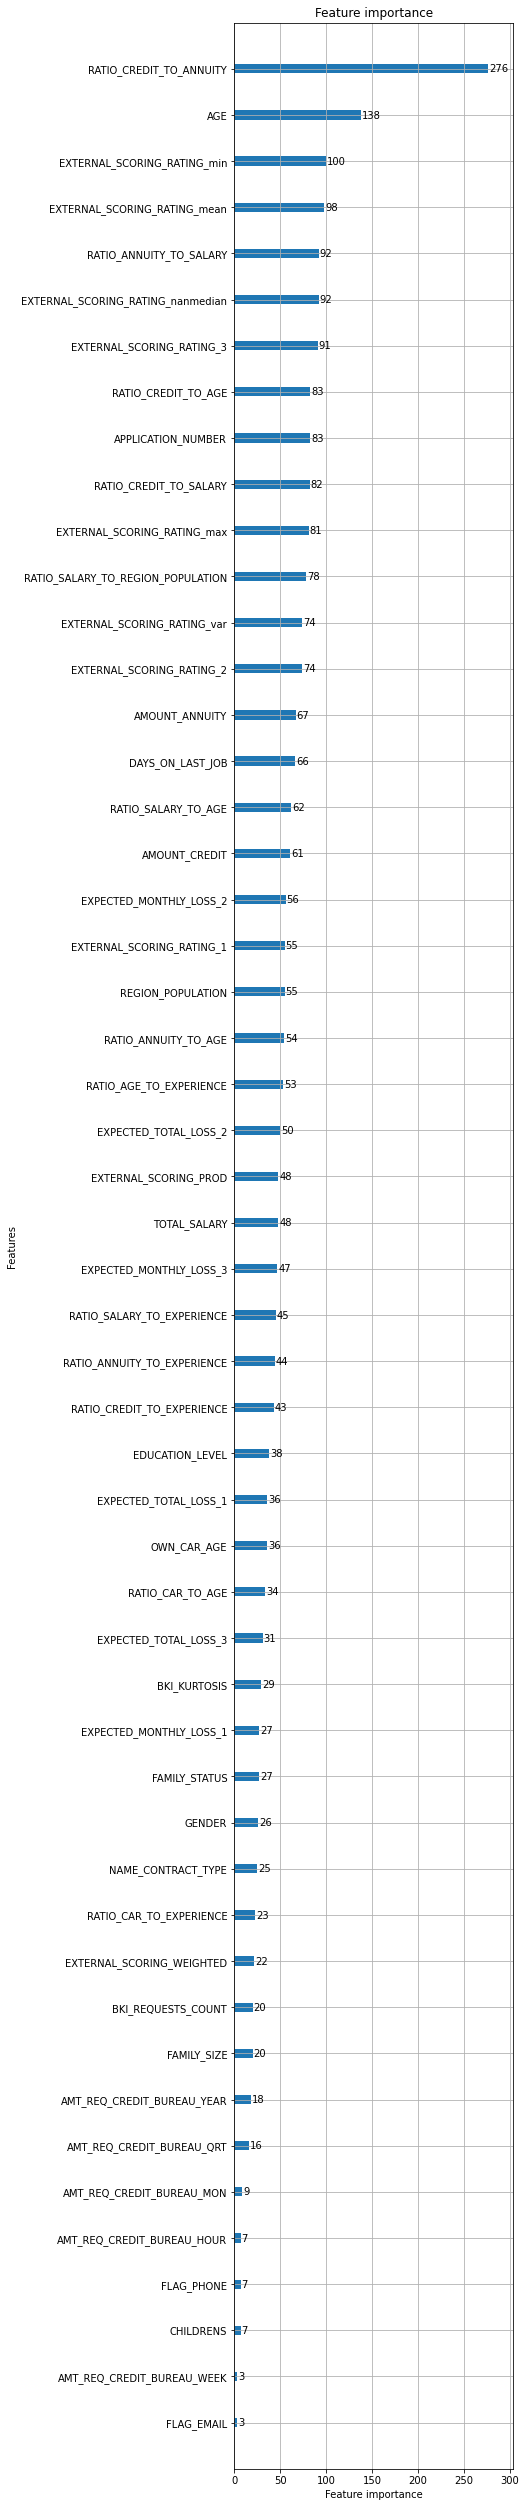

In [41]:
ax = lgbm.plot_importance(model, max_num_features=355, figsize=(5,45))   #, figsize=(45,5)
plt.show()

### Permutation importance

In [42]:
def calculate_permutation_importance(estimator, 
                                     metric: callable,
                                     x_valid: pd.DataFrame,
                                     y_valid: pd.Series) -> pd.Series:
    """
    Расчет пермутированной важности признаков.
    """
    scores = {}
    y_pred = estimator.predict(x_valid)
    base_score = metric(y_valid, y_pred)

    for feature in tqdm(x_valid.columns):
        x_valid_copy = x_valid.copy()
        x_valid_copy[feature] = np.random.permutation(x_valid_copy[feature])

        y_pred = estimator.predict(x_valid_copy)
        score = metric(y_valid, y_pred)
        scores[feature] = base_score - score

    scores = pd.Series(scores)
    scores = scores.sort_values(ascending=False)

    return scores

In [43]:
train_data = lgbm.Dataset(X_train, label=y_train)
test_data = lgbm.Dataset(X_valid, label=y_valid)

model = lgbm.train(lgbm_params,
                   train_data,
                   valid_sets=test_data,
                   num_boost_round=1000,
                   early_stopping_rounds=50,
                   verbose_eval=False)

[LightGBM] [Info] Number of positive: 7184, number of negative: 80890
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016736 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9244
[LightGBM] [Info] Number of data points in the train set: 88074, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.081568 -> initscore=-2.421234
[LightGBM] [Info] Start training from score -2.421234


In [44]:
perm_importance = calculate_permutation_importance(
    estimator=model, metric=roc_auc_score, x_valid=X_valid, y_valid=y_valid
)
perm_importance

100%|██████████| 53/53 [00:04<00:00, 12.24it/s]


EXTERNAL_SCORING_RATING_mean         0.087654
RATIO_CREDIT_TO_ANNUITY              0.018037
RATIO_ANNUITY_TO_EXPERIENCE          0.014275
EDUCATION_LEVEL                      0.009829
EXTERNAL_SCORING_RATING_2            0.007632
RATIO_CREDIT_TO_AGE                  0.007616
NAME_CONTRACT_TYPE                   0.007559
EXTERNAL_SCORING_RATING_min          0.007331
EXTERNAL_SCORING_RATING_nanmedian    0.007265
EXTERNAL_SCORING_RATING_3            0.006672
EXPECTED_MONTHLY_LOSS_3              0.006505
EXTERNAL_SCORING_PROD                0.006049
AGE                                  0.005902
GENDER                               0.004178
RATIO_CREDIT_TO_SALARY               0.004094
RATIO_SALARY_TO_AGE                  0.003783
TOTAL_SALARY                         0.003763
OWN_CAR_AGE                          0.003611
EXTERNAL_SCORING_RATING_max          0.003399
EXPECTED_MONTHLY_LOSS_2              0.003345
RATIO_AGE_TO_EXPERIENCE              0.002815
EXPECTED_TOTAL_LOSS_1             

### SHAP

In [45]:
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(model_xgb)
shap_values = explainer.shap_values(X_train)

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:])

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


Из 53 признаков наибольший вклад: 
   - в пользу fraud=1 внесли DAYS_ON_LAST_JOB и RATIO_CAR_TO_AGE и т.д.
   - в пользу fraud=0 внесли (по убыванию): APPLICATION_NUMBER, AGE, EXTERNAL_SCORING_RATING_min и т.д.
<br>Результирующее значение -7 (не fraud)

In [66]:
client = 2048
shap.force_plot(explainer.expected_value, shap_values[client,:], X_train.iloc[client,:])

Из 53 признаков наибольший вклад: 
   - в пользу fraud=1 внесли (по убыванию): AGE, APPLICATION_NUMBER и т.д.
   - в пользу fraud=0 внесли (по убыванию): EXPECTED_TOTAL_LOSS, EDUCATION_LEVEL, EXPECTED_MONTHLY_LOSS_3 и т.д.
<br>Результирующее значение -3.25 (не fraud, но не так как -7 пред клиента)

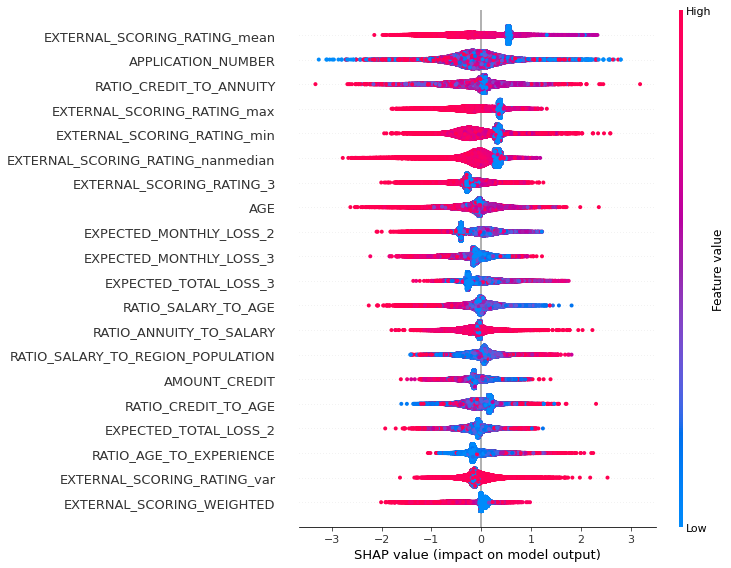

In [46]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X_train)

При повышении значения EXTERNAL_SCORING_RATING_mean (самого важного признака) снижается вероятность fraud (зависимость не линейная (см. ниже), но связь есть), аналогично ведут себя подобные деривативы от EXTERNAL_SCORING_RATING - max, min, nanmedian

APPLICATION_NUMBER грязный, т.е. неоднозначный признак . да ещё основная масса значений около 0 надо дополнительно исследовать. Зависимость не очевидна. Кстати, RATIO_CRDIT_TO_ANNUITY ведёт себя аналогично.

AGE клиенты более сташего возраста менее склоныы к fraud (не без исключений конечно)

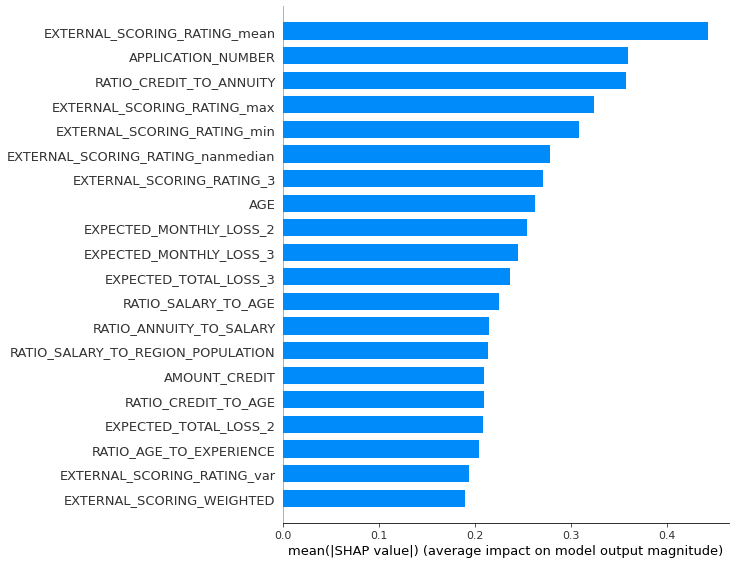

In [47]:
shap.summary_plot(shap_values, X_train, plot_type="bar")

Список самых важных признаков (в порядке по убыванию)

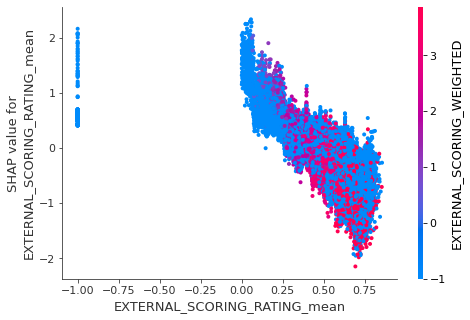

In [54]:
shap.dependence_plot('EXTERNAL_SCORING_RATING_mean', shap_values, X_train)

Наглядная демострация влияния EXTERNAL_SCORING_RATING_mean на целевую переменную (вероятность fraud). Зависимость обратная, чим больше EXTERNAL_SCORING_RATING_mean, тем реже fraud. Цветом обозначено влияние EXTERNAL_SCORING_WEIGHTED на EXTERNAL_SCORING_RATING_mean - чем больше оба эти признака тем реже fraud

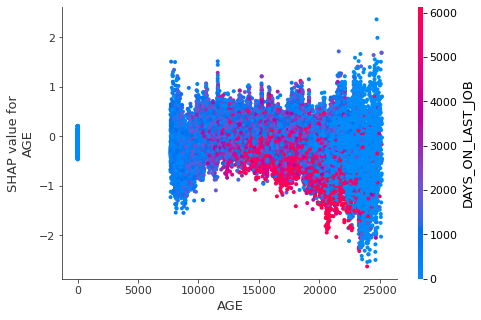

In [57]:
shap.dependence_plot('AGE', shap_values, X_train)

Очень лохматый признак. Заметно, что fraud чаще случается среди самых молодых клиентов, а с возрастом вероятность несколко снижается. Также заметно, что чем выше стаж, тем ниже веротность fraud.